In [16]:
import pandas as pd
import os, sys
import numpy as np

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../..')))

from utils.prediction_utils import *

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, r2_score

import xgboost as xgb

random_seed = 42

In [2]:
base_dir = "/Users/andrew/Desktop/Harvard/idreos-research/gpu_profiling"
X, y = get_data("conv2d", base_dir, sample_rate=1.0)
X.info()

/Users/andrew/Desktop/Harvard/idreos-research/gpu_profiling/utils/time_utils.py:216: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(dfs, axis=0, ignore_index=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 685125 entries, 0 to 685124
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   b             685125 non-null  int64  
 1   in_channels   685125 non-null  int64  
 2   iH            685125 non-null  int64  
 3   iW            685125 non-null  int64  
 4   out_channels  685125 non-null  int64  
 5   groups        685125 non-null  int64  
 6   kH            685125 non-null  int64  
 7   kW            685125 non-null  int64  
 8   stride        685125 non-null  int64  
 9   dilation      685125 non-null  int64  
 10  gflops        685125 non-null  float64
 11  dtype_16      685125 non-null  bool   
 12  dtype_32      685125 non-null  bool   
 13  dtype_b16     685125 non-null  bool   
 14  transposed_0  685125 non-null  bool   
 15  transposed_1  685125 non-null  bool   
dtypes: bool(5), float64(1), int64(10)
memory usage: 60.8 MB


In [3]:
df = pd.concat([X, y], axis=1)
df = df.query("time > 0").dropna()
X, y = df.drop(["time"], axis=1), df["time"]

In [4]:
X_train, X_val, X_test, y_train, y_val, y_test = get_train_test_split(X, y, return_concat=False)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 444058 entries, 178626 to 121958
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   b             444058 non-null  int64  
 1   in_channels   444058 non-null  int64  
 2   iH            444058 non-null  int64  
 3   iW            444058 non-null  int64  
 4   out_channels  444058 non-null  int64  
 5   groups        444058 non-null  int64  
 6   kH            444058 non-null  int64  
 7   kW            444058 non-null  int64  
 8   stride        444058 non-null  int64  
 9   dilation      444058 non-null  int64  
 10  gflops        444058 non-null  float64
 11  dtype_16      444058 non-null  bool   
 12  dtype_32      444058 non-null  bool   
 13  dtype_b16     444058 non-null  bool   
 14  transposed_0  444058 non-null  bool   
 15  transposed_1  444058 non-null  bool   
dtypes: bool(5), float64(1), int64(10)
memory usage: 42.8 MB


In [5]:
X_train, X_val, X_test, y_train, y_val, y_test = get_train_test_split(X, y, return_concat=False)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 444058 entries, 178626 to 121958
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   b             444058 non-null  int64  
 1   in_channels   444058 non-null  int64  
 2   iH            444058 non-null  int64  
 3   iW            444058 non-null  int64  
 4   out_channels  444058 non-null  int64  
 5   groups        444058 non-null  int64  
 6   kH            444058 non-null  int64  
 7   kW            444058 non-null  int64  
 8   stride        444058 non-null  int64  
 9   dilation      444058 non-null  int64  
 10  gflops        444058 non-null  float64
 11  dtype_16      444058 non-null  bool   
 12  dtype_32      444058 non-null  bool   
 13  dtype_b16     444058 non-null  bool   
 14  transposed_0  444058 non-null  bool   
 15  transposed_1  444058 non-null  bool   
dtypes: bool(5), float64(1), int64(10)
memory usage: 42.8 MB


Train--------
Mean Squared Error: 11291.127957910516
MAPE: 0.03217233584837797
R-squared: 0.9780655558899157


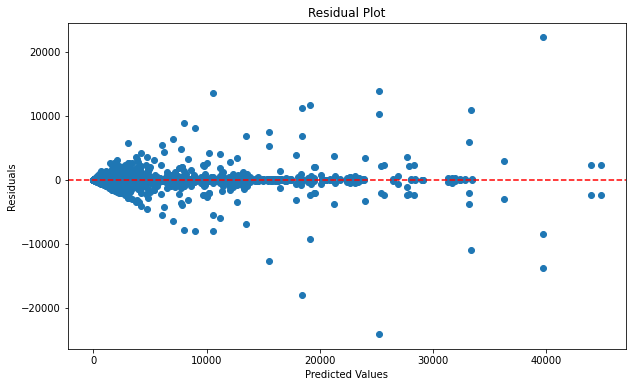

Val--------
Mean Squared Error: 77021.97028810004
MAPE: 0.10879279691486113
R-squared: 0.8693115642669834


In [11]:
tree_model = DecisionTreeRegressor(max_depth=40, min_samples_split=2, min_samples_leaf=2, max_features=100, random_state=random_seed)
tree_model.fit(X_train, y_train)

y_hat_train = tree_model.predict(X_train)
y_hat_val = tree_model.predict(X_val)

print("Train--------")
get_r2_score(y_train, y_hat_train)
plot_residuals(y_train, y_hat_train)

print("Val--------")
_ = get_r2_score(y_val, y_hat_val)

# plot_residuals(y_val, y_hat_val)

In [ ]:
feature_importances = tree_model.feature_importances_

# Create a DataFrame to view the features and their importance scores
features_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})


features_df = features_df.sort_values(by='Importance', ascending=False)
print(features_df)

         Feature  Importance
10        gflops    0.377868
5         groups    0.319552
12      dtype_32    0.112625
0              b    0.048531
15  transposed_1    0.037133
4   out_channels    0.023690
11      dtype_16    0.023328
1    in_channels    0.020110
7             kW    0.015933
6             kH    0.011826
3             iW    0.003312
14  transposed_0    0.003194
2             iH    0.002433
13     dtype_b16    0.000464
8         stride    0.000000
9       dilation    0.000000


## Random Forest

In [12]:
tree_model = RandomForestRegressor(n_estimators=30, max_depth=25, random_state=random_seed)
tree_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=25, n_estimators=30, random_state=42)

Train--------
Mean Squared Error: 4944.717655082988
MAPE: 0.06562734492955043
R-squared: 0.990394260569018


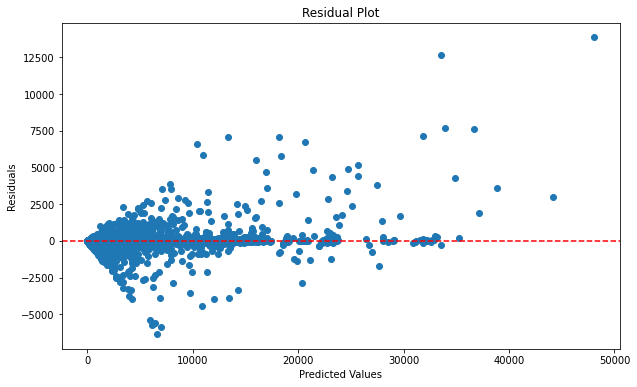

Val--------
Mean Squared Error: 41689.721111499064
MAPE: 0.1301444092664419
R-squared: 0.9292622037864265


In [13]:
y_hat_train = tree_model.predict(X_train)
y_hat_val = tree_model.predict(X_val)

print("Train--------")
get_r2_score(y_train, y_hat_train)
plot_residuals(y_train, y_hat_train)

print("Val--------")
_ = get_r2_score(y_val, y_hat_val)

# plot_residuals(y_val, y_hat_val)

In [14]:
feature_importances = tree_model.feature_importances_

# Create a DataFrame to view the features and their importance scores
features_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})


features_df = features_df.sort_values(by='Importance', ascending=False)
print(features_df)

         Feature  Importance
10        gflops    0.373447
5         groups    0.318605
12      dtype_32    0.102637
0              b    0.034980
1    in_channels    0.028125
4   out_channels    0.025738
11      dtype_16    0.022141
15  transposed_1    0.021347
14  transposed_0    0.020486
7             kW    0.018834
6             kH    0.012816
3             iW    0.009460
2             iH    0.006846
13     dtype_b16    0.004537
8         stride    0.000000
9       dilation    0.000000


# GridsearchCV

In [17]:
tree_model = DecisionTreeRegressor(random_state=random_seed)

# Parameters grid to search over
param_grid = {
    'max_depth': [10, 20, 30, 40],  # Example ranges, adjust according to your data and needs
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [2, 10, 20],
    'max_features': [50, 100, 'auto', 'sqrt']
}

# Setup the GridSearchCV
grid_search = GridSearchCV(
    estimator=tree_model, 
    param_grid=param_grid, 
    scoring=make_scorer(r2_score),  # Use R-squared as the performance metric
    cv=5,                           # Number of cross validation folds
    # verbose=2,                      # Higher number gives more information about the process
    n_jobs=-1                       # Use all available cores
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best model result
print("Best parameters found: ", grid_search.best_params_)
print("Best R-squared found: ", grid_search.best_score_)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV] END max_depth=10, max_features=50, min_samples_leaf=2, min_samples_split=2; total time=   1.3s
[CV] END max_depth=10, max_features=50, min_samples_leaf=2, min_samples_split=2; total time=   1.3s
[CV] END max_depth=10, max_features=50, min_samples_leaf=2, min_samples_split=10; total time=   1.3s
[CV] END max_depth=10, max_features=50, min_samples_leaf=2, min_samples_split=10; total time=   1.5s
[CV] END max_depth=10, max_features=50, min_samples_leaf=2, min_samples_split=10; total time=   1.5s
[CV] END max_depth=10, max_features=50, min_samples_leaf=2, min_samples_split=10; total time=   1.5s
[CV] END max_depth=10, max_features=50, min_samples_leaf=2, min_samples_split=10; total time=   1.6s
[CV] END max_depth=10, max_features=50, min_samples_leaf=2, min_samples_split=2; total time=   1.6s
[CV] END max_depth=10, max_features=50, min_samples_leaf=2, min_samples_split=2; total time=   1.6s
[CV] END max_depth=10, max_featu

/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[CV] END max_depth=10, max_features=100, min_samples_leaf=20, min_samples_split=10; total time=   1.3s
[CV] END max_depth=10, max_features=100, min_samples_leaf=20, min_samples_split=10; total time=   1.3s


/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[CV] END max_depth=10, max_features=100, min_samples_leaf=20, min_samples_split=20; total time=   1.3s
[CV] END max_depth=10, max_features=100, min_samples_leaf=20, min_samples_split=20; total time=   1.3s
[CV] END max_depth=10, max_features=100, min_samples_leaf=20, min_samples_split=20; total time=   1.3s


/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[CV] END max_depth=10, max_features=100, min_samples_leaf=20, min_samples_split=20; total time=   1.3s


/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[CV] END max_depth=10, max_features=100, min_samples_leaf=20, min_samples_split=20; total time=   1.3s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2; total time=   1.3s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2; total time=   1.2s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2; total time=   1.3s


/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, expli

[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2; total time=   1.2s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2; total time=   1.2s


/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10; total time=   1.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10; total time=   1.2s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10; total time=   1.1s


/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10; total time=   1.1s


/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=20; total time=   1.7s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=20; total time=   1.7s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10; total time=   1.9s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=20; total time=   1.8s


/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, expli

[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=20; total time=   1.7s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=20; total time=   1.9s


/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=2; total time=   1.9s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=2; total time=   2.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=2; total time=   1.9s


/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=2; total time=   1.3s


/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=2; total time=   1.2s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10; total time=   1.2s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10; total time=   1.2s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10; total time=   1.2s


/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, expli

[CV] END max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10; total time=   1.2s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10; total time=   1.2s


/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=20; total time=   1.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=20; total time=   1.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=20; total time=   1.1s


/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=20; total time=   1.1s


/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=20; total time=   1.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=20, min_samples_split=2; total time=   1.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=20, min_samples_split=2; total time=   1.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=20, min_samples_split=2; total time=   1.1s


/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, expli

[CV] END max_depth=10, max_features=auto, min_samples_leaf=20, min_samples_split=2; total time=   1.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=20, min_samples_split=2; total time=   1.0s


/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=20, min_samples_split=10; total time=   1.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=20, min_samples_split=10; total time=   1.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=20, min_samples_split=10; total time=   1.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=20, min_samples_split=10; total time=   1.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2; total time=   0.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2; total time=   0.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2; total time=   0.3s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=20, min_samples_split=20; total time=   1.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=20, min_samples_split=10; total time=   1.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=20, min_sam

/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, expli

[CV] END max_depth=20, max_features=100, min_samples_leaf=20, min_samples_split=10; total time=   1.6s
[CV] END max_depth=20, max_features=100, min_samples_leaf=20, min_samples_split=20; total time=   1.6s
[CV] END max_depth=20, max_features=100, min_samples_leaf=20, min_samples_split=20; total time=   1.7s
[CV] END max_depth=20, max_features=100, min_samples_leaf=20, min_samples_split=20; total time=   1.7s


/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, expli

[CV] END max_depth=20, max_features=100, min_samples_leaf=20, min_samples_split=20; total time=   1.8s
[CV] END max_depth=20, max_features=100, min_samples_leaf=20, min_samples_split=20; total time=   1.8s


/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2; total time=   2.1s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2; total time=   2.1s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2; total time=   2.1s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2; total time=   2.2s


/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, expli

[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2; total time=   2.1s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10; total time=   2.1s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10; total time=   2.0s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10; total time=   2.1s


/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, expli

[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10; total time=   2.1s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10; total time=   2.0s


/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20; total time=   1.9s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20; total time=   1.9s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20; total time=   1.9s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20; total time=   1.9s


/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, expli

[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=20; total time=   1.9s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=2; total time=   1.9s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=2; total time=   1.8s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=2; total time=   1.8s


/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, expli

[CV] END max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=2; total time=   1.8s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=2; total time=   1.9s


/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10; total time=   1.8s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10; total time=   1.8s


/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10; total time=   1.9s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10; total time=   1.9s


/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10; total time=   1.8s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20; total time=   1.8s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20; total time=   1.9s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20; total time=   2.1s


/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, expli

[CV] END max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20; total time=   2.2s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=20; total time=   2.1s


/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=20, min_samples_split=2; total time=   2.1s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=20, min_samples_split=2; total time=   2.1s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=20, min_samples_split=2; total time=   2.1s


/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=20, min_samples_split=2; total time=   2.2s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=20, min_samples_split=2; total time=   2.1s


/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=20, min_samples_split=10; total time=   2.1s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=20, min_samples_split=10; total time=   2.0s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=20, min_samples_split=10; total time=   2.0s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=20, min_samples_split=10; total time=   2.0s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=20, min_samples_split=10; total time=   1.9s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2; total time=   0.5s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2; total time=   0.5s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2; total time=   0.5s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2; total time=   0.5s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_sample

/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, expli

[CV] END max_depth=30, max_features=100, min_samples_leaf=20, min_samples_split=10; total time=   1.9s


/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[CV] END max_depth=30, max_features=100, min_samples_leaf=20, min_samples_split=20; total time=   1.9s
[CV] END max_depth=30, max_features=100, min_samples_leaf=20, min_samples_split=20; total time=   1.9s
[CV] END max_depth=30, max_features=100, min_samples_leaf=20, min_samples_split=20; total time=   1.9s
[CV] END max_depth=30, max_features=100, min_samples_leaf=20, min_samples_split=20; total time=   1.8s
[CV] END max_depth=30, max_features=100, min_samples_leaf=20, min_samples_split=20; total time=   1.8s


/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, expli

[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2; total time=   2.3s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2; total time=   2.4s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2; total time=   2.3s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2; total time=   2.4s


/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, expli

[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2; total time=   2.3s


/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10; total time=   2.2s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10; total time=   2.2s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10; total time=   2.2s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10; total time=   2.2s


/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, expli

[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10; total time=   2.3s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=20; total time=   2.4s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=20; total time=   2.5s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=20; total time=   2.4s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=20; total time=   2.4s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=20; total time=   2.4s


/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, expli

[CV] END max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=2; total time=   2.2s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=2; total time=   2.4s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=2; total time=   2.4s


/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=2; total time=   2.5s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=2; total time=   2.5s


/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10; total time=   2.7s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10; total time=   2.7s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10; total time=   2.8s


/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10; total time=   2.7s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10; total time=   2.8s


/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=20; total time=   2.8s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=20; total time=   2.8s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=20; total time=   2.8s


/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=20; total time=   2.8s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=20; total time=   2.8s


/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=20, min_samples_split=2; total time=   2.6s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=20, min_samples_split=2; total time=   2.6s


/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=20, min_samples_split=2; total time=   2.6s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=20, min_samples_split=2; total time=   2.5s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=20, min_samples_split=2; total time=   2.4s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=20, min_samples_split=10; total time=   2.3s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=20, min_samples_split=10; total time=   2.4s


/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=20, min_samples_split=10; total time=   2.3s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=20, min_samples_split=10; total time=   2.2s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=20, min_samples_split=10; total time=   2.2s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2; total time=   0.7s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2; total time=   0.7s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2; total time=   0.7s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2; total time=   0.7s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2; total time=   0.7s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10; total time=   0.6s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_s

/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[CV] END max_depth=40, max_features=100, min_samples_leaf=20, min_samples_split=10; total time=   2.4s
[CV] END max_depth=40, max_features=100, min_samples_leaf=20, min_samples_split=10; total time=   2.6s
[CV] END max_depth=40, max_features=100, min_samples_leaf=20, min_samples_split=10; total time=   2.6s


/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[CV] END max_depth=40, max_features=100, min_samples_leaf=20, min_samples_split=20; total time=   2.2s
[CV] END max_depth=40, max_features=100, min_samples_leaf=20, min_samples_split=20; total time=   1.9s
[CV] END max_depth=40, max_features=100, min_samples_leaf=20, min_samples_split=20; total time=   1.9s
[CV] END max_depth=40, max_features=100, min_samples_leaf=20, min_samples_split=20; total time=   2.0s


/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, expli

[CV] END max_depth=40, max_features=100, min_samples_leaf=20, min_samples_split=20; total time=   2.1s


/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[CV] END max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=2; total time=   2.6s
[CV] END max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=2; total time=   2.6s


/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[CV] END max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=2; total time=   2.4s
[CV] END max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=2; total time=   2.5s
[CV] END max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=2; total time=   2.4s


/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[CV] END max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10; total time=   2.3s
[CV] END max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10; total time=   2.3s
[CV] END max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10; total time=   2.3s
[CV] END max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10; total time=   2.3s


/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, expli

[CV] END max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10; total time=   2.0s


/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[CV] END max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=20; total time=   1.9s
[CV] END max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=20; total time=   1.9s
[CV] END max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=20; total time=   1.9s


/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[CV] END max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=20; total time=   1.9s
[CV] END max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=20; total time=   1.9s


/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[CV] END max_depth=40, max_features=auto, min_samples_leaf=10, min_samples_split=2; total time=   1.9s
[CV] END max_depth=40, max_features=auto, min_samples_leaf=10, min_samples_split=2; total time=   1.8s
[CV] END max_depth=40, max_features=auto, min_samples_leaf=10, min_samples_split=2; total time=   1.9s
[CV] END max_depth=40, max_features=auto, min_samples_leaf=10, min_samples_split=2; total time=   1.9s


/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, expli

[CV] END max_depth=40, max_features=auto, min_samples_leaf=10, min_samples_split=2; total time=   1.9s


/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[CV] END max_depth=40, max_features=auto, min_samples_leaf=10, min_samples_split=10; total time=   2.0s
[CV] END max_depth=40, max_features=auto, min_samples_leaf=10, min_samples_split=10; total time=   1.8s
[CV] END max_depth=40, max_features=auto, min_samples_leaf=10, min_samples_split=10; total time=   2.0s
[CV] END max_depth=40, max_features=auto, min_samples_leaf=10, min_samples_split=10; total time=   1.9s
[CV] END max_depth=40, max_features=auto, min_samples_leaf=10, min_samples_split=10; total time=   1.9s


/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, expli

[CV] END max_depth=40, max_features=auto, min_samples_leaf=10, min_samples_split=20; total time=   1.9s
[CV] END max_depth=40, max_features=auto, min_samples_leaf=10, min_samples_split=20; total time=   1.9s
[CV] END max_depth=40, max_features=auto, min_samples_leaf=10, min_samples_split=20; total time=   2.0s


/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[CV] END max_depth=40, max_features=auto, min_samples_leaf=10, min_samples_split=20; total time=   2.1s


/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[CV] END max_depth=40, max_features=auto, min_samples_leaf=10, min_samples_split=20; total time=   2.1s


/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[CV] END max_depth=40, max_features=auto, min_samples_leaf=20, min_samples_split=2; total time=   1.8s
[CV] END max_depth=40, max_features=auto, min_samples_leaf=20, min_samples_split=2; total time=   1.8s
[CV] END max_depth=40, max_features=auto, min_samples_leaf=20, min_samples_split=2; total time=   1.7s


/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[CV] END max_depth=40, max_features=auto, min_samples_leaf=20, min_samples_split=2; total time=   1.9s
[CV] END max_depth=40, max_features=auto, min_samples_leaf=20, min_samples_split=2; total time=   1.9s
[CV] END max_depth=40, max_features=auto, min_samples_leaf=20, min_samples_split=10; total time=   1.8s


/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[CV] END max_depth=40, max_features=auto, min_samples_leaf=20, min_samples_split=10; total time=   1.8s
[CV] END max_depth=40, max_features=auto, min_samples_leaf=20, min_samples_split=10; total time=   1.8s
[CV] END max_depth=40, max_features=auto, min_samples_leaf=20, min_samples_split=10; total time=   1.8s
[CV] END max_depth=40, max_features=auto, min_samples_leaf=20, min_samples_split=10; total time=   1.8s
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=2; total time=   0.7s
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=2; total time=   0.6s
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=2; total time=   0.8s
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=2; total time=   0.8s
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=10; total time=   0.6s
[CV] END max_depth=40, max_features=auto, min_samples_leaf=20, min_sample

In [20]:
best_tree_model = grid_search.best_estimator_
best_tree_model

DecisionTreeRegressor(max_depth=20, max_features=50, min_samples_leaf=2,
                      random_state=42)

Train--------
Mean Squared Error: 11298.561289910978
MAPE: 0.21739395308467696
R-squared: 0.9780511157023699


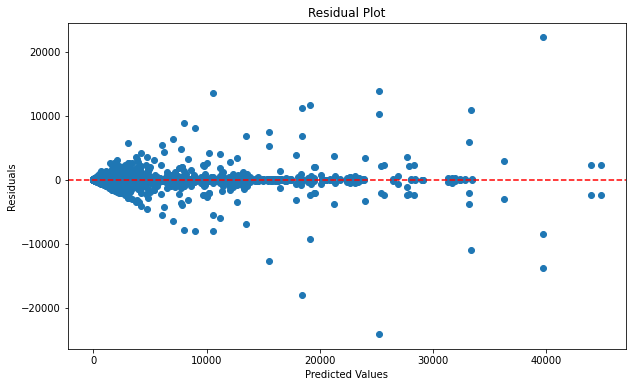

Val--------
Mean Squared Error: 53218.6669665867
MAPE: 0.25832370638860025
R-squared: 0.9097002542048169


In [22]:
best_tree_model.fit(X_train, y_train)

y_hat_train = best_tree_model.predict(X_train)
y_hat_val = best_tree_model.predict(X_val)

print("Train--------")
get_r2_score(y_train, y_hat_train)
plot_residuals(y_train, y_hat_train)

print("Val--------")
_ = get_r2_score(y_val, y_hat_val)

# plot_residuals(y_val, y_hat_val)

In [26]:
tree_model = DecisionTreeRegressor(random_state=random_seed)

# Parameters grid to search over
param_grid = {
    'max_depth': [10, 20, 30, 40],  # Example ranges, adjust according to your data and needs
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [2, 10, 20],
    'max_features': [50, 100, 'auto', 'sqrt']
}

# Setup the GridSearchCV
grid_search = GridSearchCV(
    estimator=tree_model, 
    param_grid=param_grid, 
    scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False),  # Use R-squared as the performance metric
    cv=5,                           # Number of cross validation folds
    # verbose=2,                      # Higher number gives more information about the process
    n_jobs=-1                       # Use all available cores
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best model result
print("Best parameters found: ", grid_search.best_params_)
print("Best R-squared found: ", grid_search.best_score_)

/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, expli

Best parameters found:  {'max_depth': 40, 'max_features': 50, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best R-squared found:  -0.13194901363193395


In [27]:
best_tree_model = grid_search.best_estimator_
best_tree_model

DecisionTreeRegressor(max_depth=40, max_features=50, min_samples_leaf=2,
                      random_state=42)

Train--------
Mean Squared Error: 11291.127957910516
MAPE: 0.03217233584837797
R-squared: 0.9780655558899157


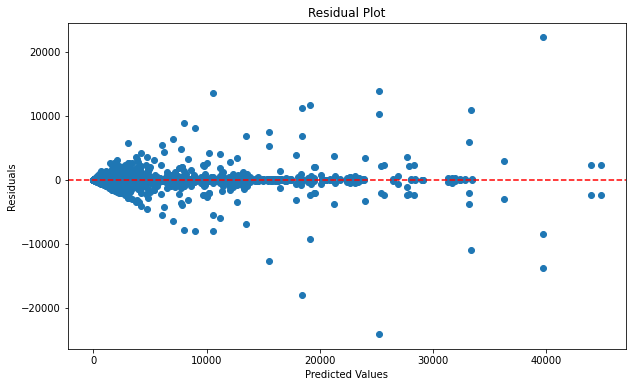

Val--------
Mean Squared Error: 77021.97028810004
MAPE: 0.10879279691486113
R-squared: 0.8693115642669834


In [28]:
best_tree_model.fit(X_train, y_train)

y_hat_train = best_tree_model.predict(X_train)
y_hat_val = best_tree_model.predict(X_val)

print("Train--------")
get_r2_score(y_train, y_hat_train)
plot_residuals(y_train, y_hat_train)

print("Val--------")
_ = get_r2_score(y_val, y_hat_val)

# plot_residuals(y_val, y_hat_val)

In [29]:
tree_model = DecisionTreeRegressor(random_state=random_seed)

# Parameters grid to search over
param_grid = {
    'max_depth': [10, 20, 30, 40],  # Example ranges, adjust according to your data and needs
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [2, 10, 20],
    'max_features': [50, 100, 'auto', 'sqrt']
}

# Setup the GridSearchCV
grid_search = GridSearchCV(
    estimator=tree_model, 
    param_grid=param_grid, 
    scoring=make_scorer(mean_squared_error, greater_is_better=False),  # Use R-squared as the performance metric
    cv=5,                           # Number of cross validation folds
    # verbose=2,                      # Higher number gives more information about the process
    n_jobs=-1                       # Use all available cores
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best model result
print("Best parameters found: ", grid_search.best_params_)
print("Best R-squared found: ", grid_search.best_score_)

/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/opt/miniconda3/envs/research/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, expli

Best parameters found:  {'max_depth': 20, 'max_features': 50, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best R-squared found:  -54319.93440332201


In [30]:
best_tree_model = grid_search.best_estimator_
best_tree_model

DecisionTreeRegressor(max_depth=20, max_features=50, min_samples_leaf=2,
                      random_state=42)

Train--------
Mean Squared Error: 11298.561289910978
MAPE: 0.21739395308467696
R-squared: 0.9780511157023699


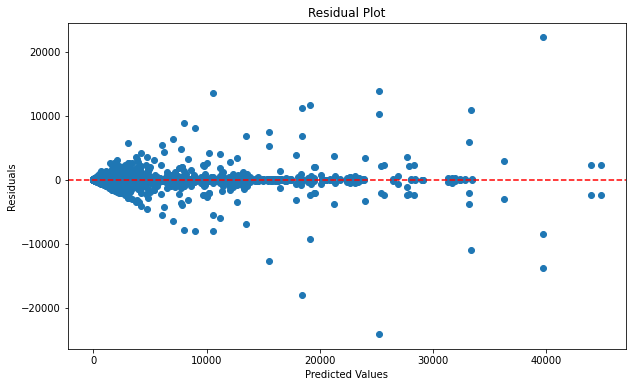

Val--------
Mean Squared Error: 53218.6669665867
MAPE: 0.25832370638860025
R-squared: 0.9097002542048169


In [31]:
best_tree_model.fit(X_train, y_train)

y_hat_train = best_tree_model.predict(X_train)
y_hat_val = best_tree_model.predict(X_val)

print("Train--------")
get_r2_score(y_train, y_hat_train)
plot_residuals(y_train, y_hat_train)

print("Val--------")
_ = get_r2_score(y_val, y_hat_val)

# plot_residuals(y_val, y_hat_val)